# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
x = datasets.MNIST('data')
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [4]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [5]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

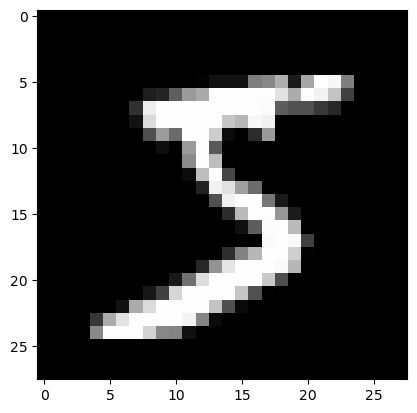

In [7]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

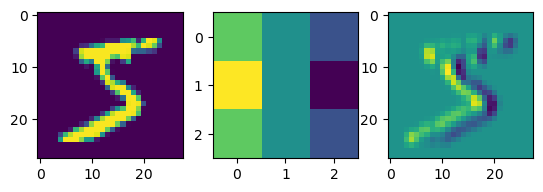

In [8]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [11]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [12]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

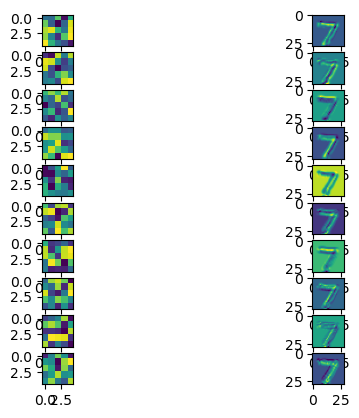

In [13]:
visualize()

# Predict Using Network

In [14]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [15]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([0, 2, 4, 4, 3])

# First Test and Train

In [16]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [17]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 10%



In [18]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [19]:
train()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.305118
Train loss: 1.932119
Train loss: 1.060777
Train loss: 0.856302
Train loss: 0.652275
Train loss: 0.667469
Train loss: 0.466259
Train loss: 0.530681
Train loss: 0.360448
Train loss: 0.687057


# Train Network

In [20]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.354621
Train loss: 2.192364
Train loss: 1.189558
Train loss: 0.861163
Train loss: 0.692747
Train loss: 0.803114
Train loss: 0.578879
Train loss: 0.590235
Train loss: 0.593546
Train loss: 0.533767
Test accuracy: 94%

Train loss: 0.404617
Train loss: 0.378110
Train loss: 0.323816
Train loss: 0.487125
Train loss: 0.225990
Train loss: 0.468098
Train loss: 0.388130
Train loss: 0.394228
Train loss: 0.360347
Train loss: 0.460460
Test accuracy: 96%

Train loss: 0.215342
Train loss: 0.288127
Train loss: 0.244198
Train loss: 0.411961
Train loss: 0.147909
Train loss: 0.202070
Train loss: 0.193970
Train loss: 0.313981
Train loss: 0.247601
Train loss: 0.353094
Test accuracy: 97%

Train loss: 0.226720
Train loss: 0.252056
Train loss: 0.284093
Train loss: 0.255921
Train loss: 0.173940
Train loss: 0.174609
Train loss: 0.203166
Train loss: 0.354991
Train loss: 0.345742
Train loss: 0.223287
Test accuracy: 97%

Train loss: 0.178099
Train loss: 0.314706
Train loss: 0.174584
Train loss: 0.235

# Inspect Network

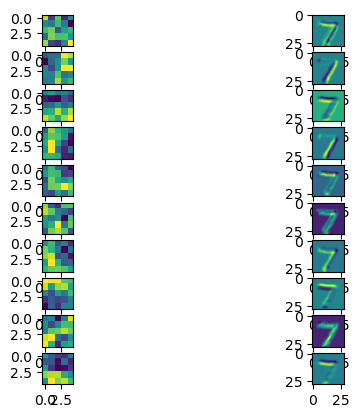

In [21]:
visualize()

In [22]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [23]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?
- How do the weights looks different when trained with 60,000 vs 600?

In [24]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [25]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.332946
Train loss: 1.729413
Train loss: 0.883260
Train loss: 0.820924
Train loss: 0.820855
Test accuracy: 91%

Train loss: 0.466990
Train loss: 0.483790
Train loss: 0.468112
Train loss: 0.550456
Train loss: 0.495225
Test accuracy: 95%

Train loss: 0.393658
Train loss: 0.261624
Train loss: 0.496278
Train loss: 0.402889
Train loss: 0.373173
Test accuracy: 96%

Train loss: 0.205661
Train loss: 0.352295
Train loss: 0.234549
Train loss: 0.309807
Train loss: 0.266849
Test accuracy: 96%

Train loss: 0.232757
Train loss: 0.315851
Train loss: 0.181878
Train loss: 0.413550
Train loss: 0.224536
Test accuracy: 97%



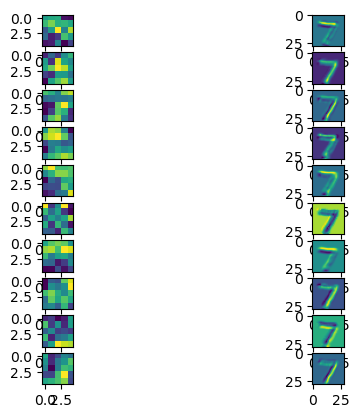

In [26]:
visualize()

# Question 1a
- What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?

- As shown above, with 30k we start at 91% and get to 97% over 5 epochs.

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.270057
Train loss: 1.776965
Train loss: 0.892841
Train loss: 0.772016
Train loss: 0.763502
Train loss: 0.514373
Train loss: 0.472107
Train loss: 0.703670
Train loss: 0.764762
Train loss: 0.564254
Test accuracy: 94%

Train loss: 0.375328
Train loss: 0.518344
Train loss: 0.299400
Train loss: 0.516805
Train loss: 0.471517
Train loss: 0.346224
Train loss: 0.396439
Train loss: 0.415716
Train loss: 0.382255
Train loss: 0.356291
Test accuracy: 96%

Train loss: 0.225993
Train loss: 0.153451
Train loss: 0.329685
Train loss: 0.339740
Train loss: 0.223336
Train loss: 0.419985
Train loss: 0.211354
Train loss: 0.516480
Train loss: 0.227773
Train loss: 0.256827
Test accuracy: 97%

Train loss: 0.330827
Train loss: 0.416234
Train loss: 0.243405
Train loss: 0.406503
Train loss: 0.125819
Train loss: 0.171988
Train loss: 0.180188
Train loss: 0.326801
Train loss: 0.425852
Train loss: 0.364116
Test accuracy: 97%

Train loss: 0.228118
Train loss: 0.229167
Train loss: 0.140619
Train loss: 0.216

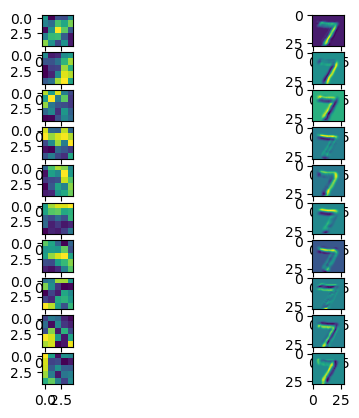

In [27]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

- After 5 epochs of training we went from 94% accuracy to 98% accuracy.

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.331810
Test accuracy: 54%

Train loss: 2.031204
Test accuracy: 79%

Train loss: 1.200270
Test accuracy: 86%

Train loss: 0.888318
Test accuracy: 89%

Train loss: 0.844331
Test accuracy: 90%



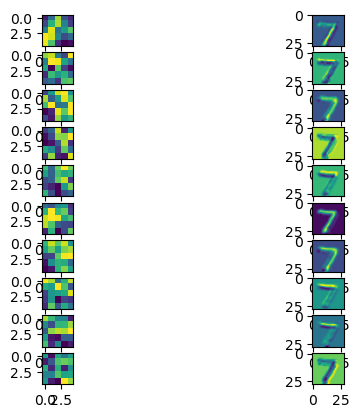

In [28]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

- At 6k we start with 51% accuracy and end at 90%.

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.316293
Test accuracy: 21%

Train loss: 2.271028
Test accuracy: 58%

Train loss: 2.087334
Test accuracy: 65%

Train loss: 1.755826
Test accuracy: 77%

Train loss: 1.449167
Test accuracy: 84%



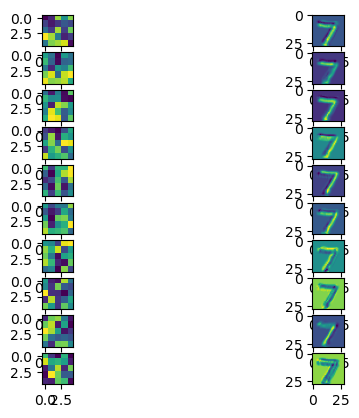

In [29]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

- At 3k we start at 21% and get up to 84%.

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20334/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.371666
Test accuracy: 14%

Train loss: 2.311270
Test accuracy: 24%

Train loss: 2.253734
Test accuracy: 23%

Train loss: 2.286599
Test accuracy: 23%

Train loss: 2.240763
Test accuracy: 29%



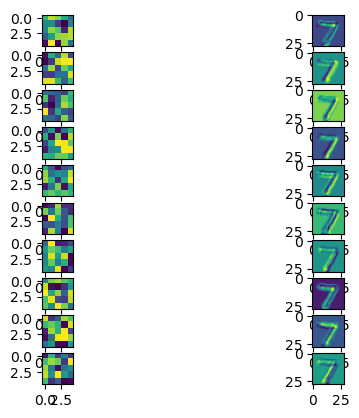

In [30]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

visualize()

- At 600 we start with 14% accuracy and get up to 29%. Hardly any improvement at all.

# Question 1B

- As you decrease the number of images it trains with, there is a clear decrease in the quality of the weights. They appear far more random as you decrease the number of training images.